In [1]:
from datetime import datetime
from time import time
from contextlib import contextmanager
from typing import List, Union

import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr,kruskal
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from minisom import MiniSom

from tsai.all import *

import optuna


from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *

from torch_optimizer import *

os.environ["DEVICE"] = "cuda"

## Pré-processamento dos dados

### Cálculo do GPP

In [2]:
@contextmanager
def cwd(path: str) -> None:

    """
    Context manager para mudar o diretório de trabalho.
    Mantém o diretório original após a execução do bloco de código.
    """

    oldpwd = os.getcwd()
    os.chdir(path)
    try:
        yield
    finally:
        os.chdir(oldpwd)

def constructor_2(path):
    df = pd.read_csv(path, parse_dates=['date'])
    # Definindo a coluna 'system:time_start' como índice
    hora_inicio = df['date'].min().floor('d')
    df.index = hora_inicio + pd.to_timedelta(df.index, unit='h')
    # Removendo a coluna 'system:time_start'
    df = df.drop(['date','.geo'], axis=1)
    df = df.drop('system:index',axis=1)
    return df

def modis_date(data_str):
    ano = int(data_str[1:5])
    dia_ano = int(data_str[5:])
    data = datetime.strptime('{}-{}'.format(ano, dia_ano), '%Y-%j')
    return data

#==================================== Funções do Software do MOD17

def linear_constraint(
        xmin, xmax, form: str = None):
    assert form is None or form in ('reversed', 'binary'),\
        'Argument "form" must be None or one of: "reversed", "binary"'
    assert form == 'binary' or np.any(xmax >= xmin),\
        'xmax must be greater than/ equal to xmin'
    if form == 'reversed':
        return lambda x: np.where(x >= xmax, 0,
            np.where(x < xmin, 1, 1 - np.divide(
                np.subtract(x, xmin), xmax - xmin)))
    if form == 'binary':
        return lambda x: np.where(x == 1, xmax, xmin)
    return lambda x: np.where(x >= xmax, 1,
        np.where(x < xmin, 0,
            np.divide(np.subtract(x, xmin), xmax - xmin)))

def _gpp(params, fpar, tmin, vpd, par):
    'Daily GPP as static method, avoids overhead of class instantiation'
    # "params" argument should be a Sequence of atomic parameter values
    #   in the order prescribed by "required_parameters"
    tmin_scalar = linear_constraint(params[1], params[2])(tmin)
    vpd_scalar = linear_constraint(
        params[3], params[4], form = 'reversed')(vpd)
    lue = params[0] * tmin_scalar * vpd_scalar
    return 1e3 * lue * fpar * par

def _par(sw_rad: Number, period_hrs: Number = 1) -> Number:
    '''
    Calculates daily total photosynthetically active radiation (PAR) from
    (hourly) incoming short-wave radiation (SW_rad). PAR is assumed to
    be 45% of SW_rad.

    Parameters
    ----------
    swrad : int or float or numpy.ndarray
        Incoming short-wave radiation (W m-2)
    period_hrs : int
        Period over which radiation is measured, in hours (Default: 1)

    Returns
    -------
    int or float or numpy.ndarray
    '''
    # Convert SW_rad from [W m-2] to [MJ m-2], then take 45%;
    #   3600 secs hr-1 times (1 MJ / 1e6 Joules) == 0.0036
    return 0.45 * (0.0036 * (24 / period_hrs) * sw_rad)

def _vpd(qv10m: Number, pressure: Number, tmean: Number) -> Number:
    '''
    Computes vapor pressure deficit (VPD) from surface meteorology.

    Parameters
    ----------
    qv10m : int or float or numpy.ndarray
        Water vapor mixing ratio at 10-meter height (Pa)
    pressure : int or float or numpy.ndarray
        Atmospheric pressure (Pa)
    tmean : int or float or numpy.ndarray
        Mean daytime temperature (degrees C)

    Returns
    -------
    int or float or numpy.ndarray
    '''
    # Actual vapor pressure (Gates 1980, Biophysical Ecology, p.311)
    avp = (qv10m * pressure) / (0.622 + (0.379 * qv10m))
    # Saturation vapor pressure (similar to FAO formula)
    svp = 610.7 * np.exp((17.38 * tmean) / (239 + tmean))
    return svp - avp
#==================================== Funções do Software do MOD17



def create_drivers():
    """Função para calcular o valor dos parâmetros necessários para calcular o GPP de cada área"""
    date = 0
    drivers_dict = {}
    with cwd('dados/Merra'):
        for folder in os.listdir():
            with cwd(folder):
                csvs = sorted(os.listdir())
                tday = constructor_2(f'{csvs[4]}') - 273.15 #( K° -> C°)
                tmin = tday['T10M'].resample('D').min()['2000-02-26':].values  # Reamostrando para Temperatura mínima diária
                tmean = tday['T10M'].resample('D').mean().values  # Temperatura média diária
                tmean_vpd = tday['T10M'].between_time('9:00', '21:00').resample('D').mean()['2000-02-26':].values

                # Leitura e pré-processamento dos dados de razão de mistura de vapor de água
                qv10m = constructor_2(f'{csvs[2]}')['2000-02-26':] # unidade: "Mass fraction" (kg/kg)
                qv10m = pd.to_numeric(qv10m['QV10M']).between_time('9:00', '21:00').resample('D').mean().values

                # Leitura e pré-processamento dos dados de pressão atmosférica
                ps = constructor_2(f'{csvs[1]}') # unidade: Pa  # Removendo vírgulas dos valores
                ps['PS'] = pd.to_numeric(ps['PS'])
                ps = ps.between_time('9:00', '21:00').resample('D').mean()['2000-02-26':]
                ps = pd.to_numeric(ps['PS']).values

                # Leitura e pré-processamento dos dados de radiação solar incidente
                SWGNT = constructor_2(f'{csvs[3]}')['SWGNT'].resample('D').mean()['2000-02-26':].values # unidade: W/m^2

                # Leitura e pré-processamento dos dados de Fração de Absorção de Luz Fotossinteticamente Ativa (FPAR)
                fpar = pd.read_csv(f'{csvs[0]}', header=None,na_values='F') # unidade: (%)
                fpar.index = fpar[2].apply(modis_date)  # Convertendo a data no formato MODIS

                # Arrumando o dataframe
                # ================================
                fpar = fpar.drop([0,1,2,3,4], axis=1)
                fpar.columns = range(len(fpar.columns))
                fpar = fpar[144]

                # ================================

                # Tratamento de dados faltando usando interpolação linear (8 dias -> diário)

                fpar = fpar['2000-02-26':'2022-01-01'].resample('D').interpolate('linear')[:-1]
                fpar = fpar.values if (folder != 'amazonia peruana') and (folder != 'guiana')  else fpar.values/100


                drivers = [
                    fpar[:][...,None],
                    tmin[:][...,None],
                    _vpd(qv10m, ps, tmean_vpd)[...,None],
                    _par(SWGNT)[:][...,None]
                ]
                drivers[2] = np.where(drivers[2] < 0, 0, drivers[2]) # Set negative VPD to zero


                date = tday['T10M'].resample('D').min()['2000-02-26':].index
                drivers_dict[folder] = drivers
    return date, drivers_dict


def df_xy(x,y):
    x_df = pd.DataFrame(x[:,0]).reset_index().drop('index',axis=1)
    x_df.columns = [f'janela {i}' for i in range(len(x_df.columns))]

    y_df = pd.DataFrame(y).reset_index().drop('index',axis=1)
    y_df.columns = [f'previsao {i}' for i in range(len(y_df.columns))]

    return pd.concat([x_df,y_df],axis=1)

parametros = [0.001405, -8.0, 9.09, 1000.0, 4000.0, 26.9, 2.0, 2.0, 1.1, 0.162, 0.00604, 0.00519, 0.00397]

drivers = create_drivers()


index_date = drivers[0] # Data associada aos dados

drivers_peru, drivers_caxiuana, drivers_guiana, drivers_santarem = drivers[1].values() # Dados de cada região


gpp_peru = np.nanmean(_gpp(parametros,*drivers_peru), axis = -1) # gpp calculado

gpp_gui = np.nanmean(_gpp(parametros,*drivers_guiana), axis = -1) # gpp calculado

gpp_santarem = np.nanmean(_gpp(parametros,*drivers_santarem), axis = -1)

gpp_cax = np.nanmean(_gpp(parametros,*drivers_caxiuana), axis = -1)


gpp_peru = pd.DataFrame(gpp_peru,index=index_date)
gpp_gui = pd.DataFrame(gpp_gui,index=index_date)
gpp_santarem = pd.DataFrame(gpp_santarem,index=index_date)
gpp_cax = pd.DataFrame(gpp_cax,index=index_date)

gpp_peru = ExponentialSmoothing(gpp_peru, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues
gpp_gui = ExponentialSmoothing(gpp_gui, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues
gpp_santarem = ExponentialSmoothing(gpp_santarem, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues
gpp_cax = ExponentialSmoothing(gpp_cax, initialization_method="heuristic",freq='D').fit(optimized=True).fittedvalues

gpp_gui = pd.DataFrame(gpp_gui,columns=['gui'],index=index_date) # Convertendo de volta pra um dataframe
gpp_peru = pd.DataFrame(gpp_peru,columns=['peru'],index=index_date) # Convertendo de volta pra um dataframe
gpp_santarem = pd.DataFrame(gpp_santarem,columns=['santarem'],index=index_date)
gpp_cax = pd.DataFrame(gpp_cax,columns=['cax'],index=index_date)

In [3]:
gpp_todos = pd.concat([gpp_gui,gpp_peru,gpp_santarem,gpp_cax],axis=1)

In [4]:
train, test = train_test_split(gpp_todos,test_size=0.15,shuffle=False,random_state=1)

In [5]:
train_date = train.index
test_date = test.index

gpp_gui_train, gpp_peru_train, gpp_santarem_train, gpp_cax_train = gpp_gui.loc[train_date].copy(),gpp_peru.loc[train_date].copy(),gpp_santarem.loc[train_date].copy(),gpp_cax.loc[train_date].copy()
gpp_gui_test, gpp_peru_test, gpp_santarem_test, gpp_cax_test = gpp_gui.loc[test_date].copy(),gpp_peru.loc[test_date].copy(),gpp_santarem.loc[test_date].copy(),gpp_cax.loc[test_date].copy()

### Criação da janela temporal

In [6]:
peru_x_test,peru_y_test = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_peru_test) #  stride = n datapoints the window is moved ahead along the sequence.
                                                                                    # Default: 1. If None, stride=window_length (no overlap)
santarem_x_test,santarem_y_test = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_santarem_test)
cax_x_test,cax_y_test = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_cax_test)
gui_x_test,gui_y_test = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_gui_test)

In [7]:
peru_x,peru_y = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_peru_train) #  stride = n datapoints the window is moved ahead along the sequence.
                                                                                    # Default: 1. If None, stride=window_length (no overlap)
santarem_x,santarem_y = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_santarem_train)
cax_x,cax_y = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_cax_train)
gui_x,gui_y = SlidingWindow(8,horizon=8,seq_first=True,stride = None)(gpp_gui_train)

peru_df = df_xy(peru_x,peru_y)
santarem_df = df_xy(santarem_x,santarem_y)
cax_df = df_xy(cax_x,cax_y)
gui_df = df_xy(gui_x,gui_y)



peru_df['localidade'] = 'peru'
santarem_df['localidade'] = 'santarem'
cax_df['localidade'] = 'caxiuana'
gui_df['localidade'] = 'guiana'


gpp_geral = pd.concat([peru_df,santarem_df,cax_df,gui_df]).reset_index().drop('index',axis=1)

### Geração de Características

In [8]:
df = gpp_geral.reset_index().drop('index',axis=1)

janela = [f'janela {i}' for i in range(0,8)]
previsao = [f'previsao {i}' for i in range(0,8)]


X = df.drop(columns=['localidade']).drop(columns=previsao)  # Aqui ficam 15 colunas representado instantes da janela temporal
y = df[previsao] # Aqui fica o 8° valor da sequência
z = df[['localidade']]

ts_features_df = get_ts_features(X=X.values.reshape(X.shape[0],1,X.shape[1]),y=y.values,features='efficient')
ts_features_df = ts_features_df.dropna(axis=1)

Feature Extraction: 100%|██████████| 60/60 [01:13<00:00,  1.23s/it]


### Clusterização com SOM

In [9]:
norm = preprocessing.Normalizer()

datos = norm.fit_transform(ts_features_df.values)

quant_error = {'som':[],'quant_error':[],'sigma':[],'learning_rate':[]}

map_size = round(np.sqrt(round(5 * np.sqrt(len(ts_features_df))))) # arredondando pra um inteiro com raiz exata = 324 = 18x18

som_shape = (map_size, map_size)
som = MiniSom(som_shape[0], som_shape[1], datos.shape[1],neighborhood_function='gaussian',activation_distance='euclidean')

som.train_batch(datos, 100, verbose=False)
print(som.quantization_error(datos))
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in datos]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index

cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)
df['cluster'] = np.array(cluster_index)


# Contar o número de ocorrências de cada cluster por localidade
cluster_counts = df.groupby(['localidade', 'cluster']).size()

# Filtrar os clusters para apenas os que possuem mais de 6 ocorrências
valid_clusters = cluster_counts[cluster_counts > 6].index

# Manter apenas as linhas cujo cluster e localidade estão nos clusters e localidades válidos
teste = df[df.set_index(['localidade', 'cluster']).index.isin(valid_clusters)].copy()

0.4232995950330446


In [10]:
previsao = [f'previsao {i}' for i in range(0,8)]
X = teste.drop(columns=['localidade', 'cluster']).drop(columns=previsao)  # Aqui ficam 8 colunas representado instantes da janela temporal
y = teste[previsao] # Aqui fica o 8° valor da sequência
z = teste[['localidade','cluster']]

In [24]:
# Dividir os dados em treino e teste estratificados por 'localidade' e 'cluster'
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=z,random_state=1)

train_data = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
X_train = train_data.drop(columns=previsao)
y_train = train_data[previsao]

val_data = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
X_val = val_data.drop(columns=previsao)
y_val = val_data[previsao]

In [25]:
peru_xtest = pd.DataFrame(peru_x_test.reshape(-1, 8))
peru_ytest = pd.DataFrame(peru_y_test)
peru_ytest['localidade'] = 'peru'

santarem_xtest = pd.DataFrame(santarem_x_test.reshape(-1, 8))
santarem_ytest = pd.DataFrame(santarem_y_test)
santarem_ytest['localidade'] = 'santarem'

cax_xtest = pd.DataFrame(cax_x_test.reshape(-1, 8))
cax_ytest = pd.DataFrame(cax_y_test)
cax_ytest['localidade'] = 'caxiuana'

gui_xtest = pd.DataFrame(gui_x_test.reshape(-1, 8))
gui_ytest = pd.DataFrame(gui_y_test)
gui_ytest['localidade'] = 'guiana'

x_test_df = pd.concat([peru_xtest,
                       santarem_xtest,
                       cax_xtest,
                       gui_xtest],
                      ignore_index=True)

# Criando DataFrame apenas com os valores de destino (y_test)
y_test_df = pd.concat([pd.DataFrame(peru_ytest),
                       pd.DataFrame(santarem_ytest),
                       pd.DataFrame(cax_ytest),
                       pd.DataFrame(gui_ytest)],
                      ignore_index=True)

# Verificando os DataFrames resultantes
X_test = x_test_df.values.reshape(-1, 1, 8)

y_test = y_test_df.drop('localidade',axis=1).values
y_labels = y_test_df['localidade']

DataFrame de x_test:

DataFrame de y_test:


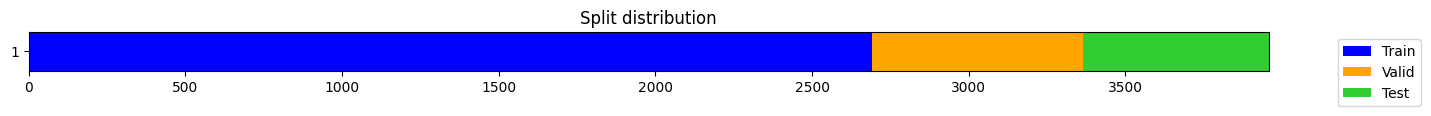

In [26]:
X_train_np = np.array(X_train)
X_val_np = np.array(X_val)
X_test_np = np.array(X_test)
y_train_np = np.array(y_train)
y_val_np = np.array(y_val)
y_test_np = np.array(y_test)

X, y, splits = combine_split_data(xs=[X_train_np, X_val_np, X_test_np], ys=[y_train_np, y_val_np, y_test_np])
plot_splits(splits)

tfms = [None, TSForecasting()]

### Testes com os Modelos

In [30]:
archs = [
         (XCMPlus, {}),
         (ConvTranPlus, {}),
         (TSSequencerPlus, {}),      # Arquiteturas que estou testando (ainda arbitrário).
         (RNNPlus, {}),                         #Os dicionários do lado do nome de cada arquitetura são específicos dos parâmetros
         (ResNetPlus, {}),                              # EX: (LSTM, {'n_layers':1, 'bidirectional': False})
         (InceptionTimePlus, {}),
         (TSTPlus, {}),
         (TransformerLSTMPlus, {}),
         (XceptionTimePlus, {}),
         (TransformerGRUPlus, {}),
         (PatchTST, {}),

        ]

otimizadores = {
  'PID': PID,
  'NovoGrad': NovoGrad,
  'QHM': QHM,
  'SGDP': SGDP,
  'SGDW': SGDW,
  'Shampoo': Shampoo,
  'SWATS': SWATS,
  'Yogi': Yogi,
  'AdaBound': AdaBound,
  'AdaMod': AdaMod,
  'AdamP': AdamP
}

,arch,hyperparams,total params,train loss,valid loss,mae_valid,rmse_valid,mae_test,rmse_test,time
0,PatchTST,{},6318090,3.547221,3.584260,3.508504,4.191595,3.498935,4.113346,1051
1,RNNPlus,{},10401,1.058209,1.364348,1.794454,2.426146,1.743161,2.378671,99
2,TransformerGRUPlus,{},792705,1.288259,1.319153,1.745629,2.369546,1.688196,2.326050,1523
3,TransformerLSTMPlus,{},858753,1.280643,1.317852,1.744531,2.368579,1.687063,2.326047,829
4,TSSequencerPlus,{},210481,0.219675,1.153633,1.568856,2.180620,1.455678,2.053231,1426
5,InceptionTimePlus,{},454977,0.039311,1.052226,1.460126,2.031057,1.405706,1.934852,865
6,ResNetPlus,{},478337,0.012987,1.027753,1.436860,1.999758,1.398202,1.927628,504
7,ConvTranPlus,{},12224,0.730716,0.987042,1.386782,1.967499,1.243253,1.752058,204
8,XceptionTimePlus,{},234865,0.603841,0.973636,1.376267,1.929024,1.247658,1.772495,1038
9,XCMPlus,{},5635,0.789305,0.959106,1.355200,1.911938,1.222915,1.725741,168


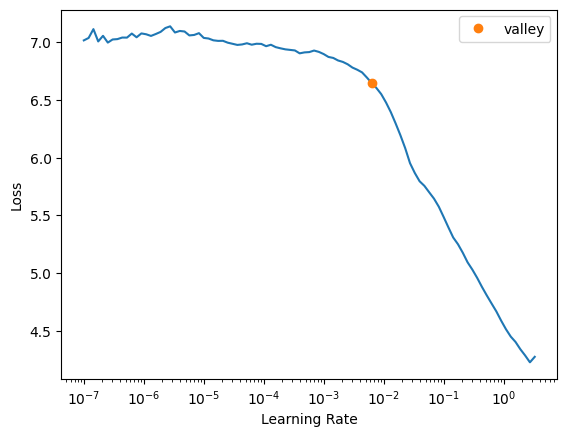

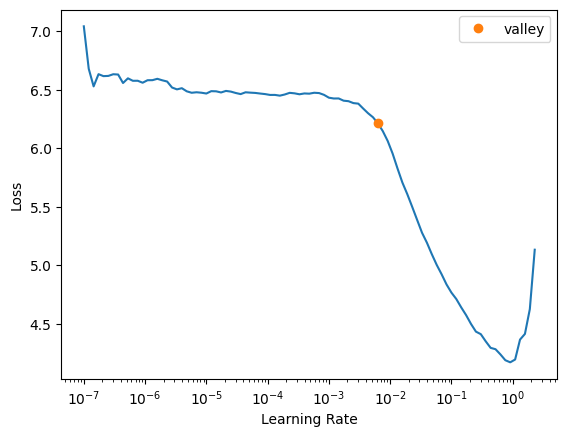

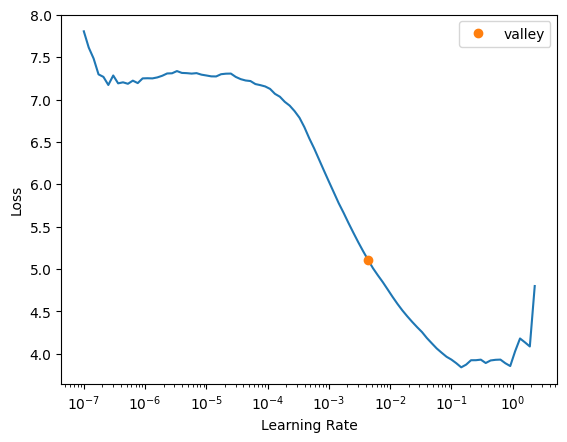

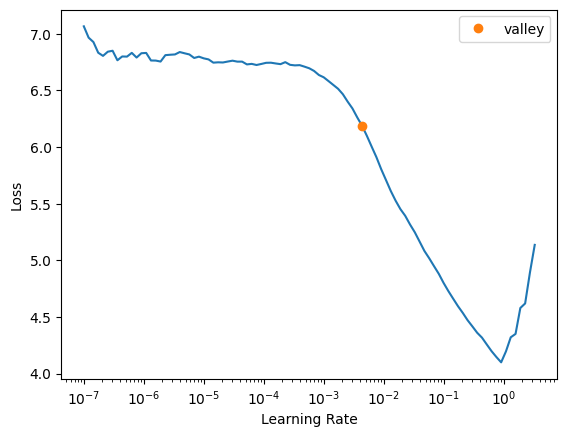

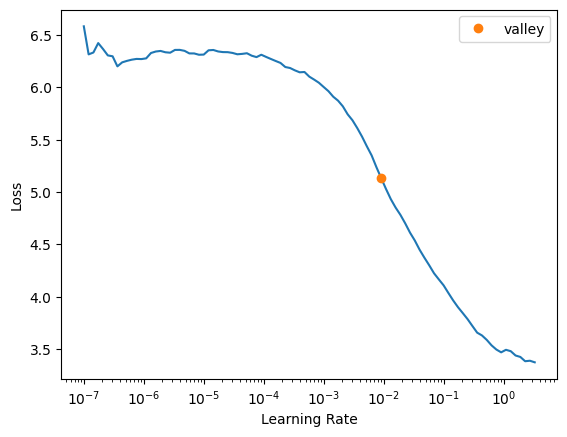

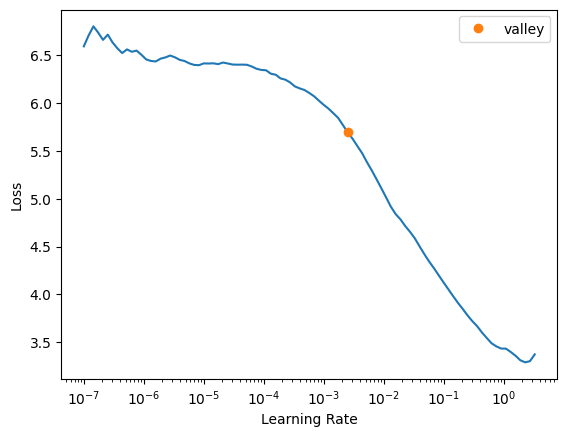

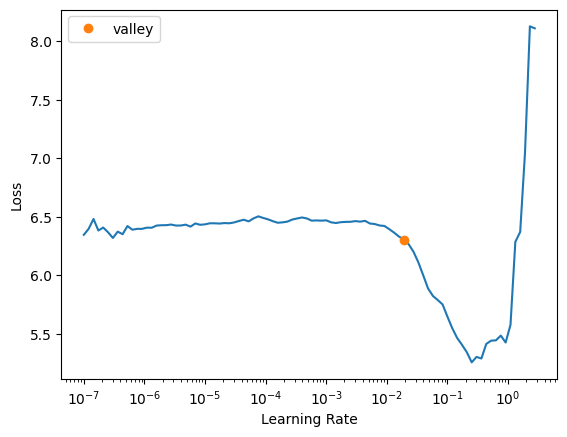

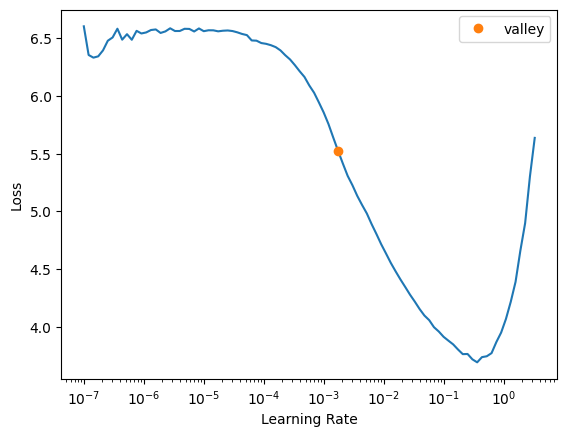

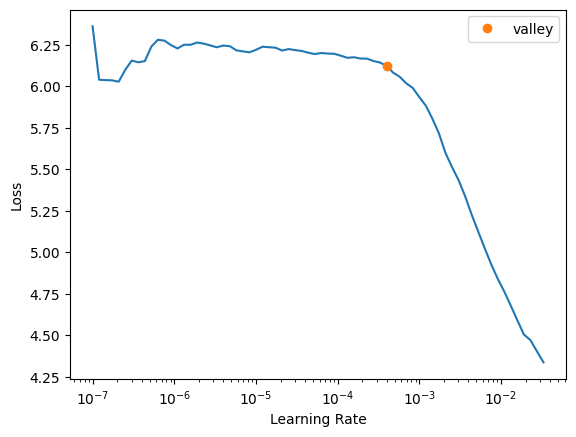

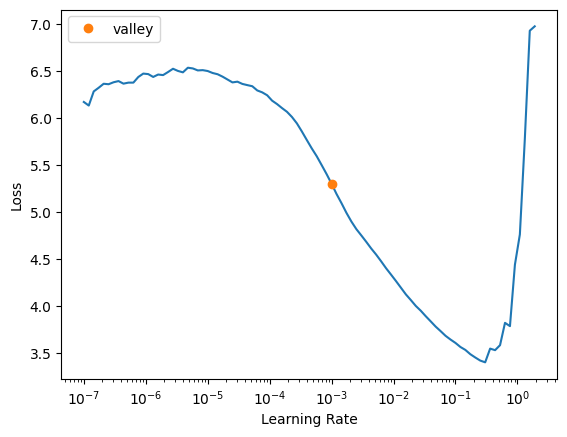

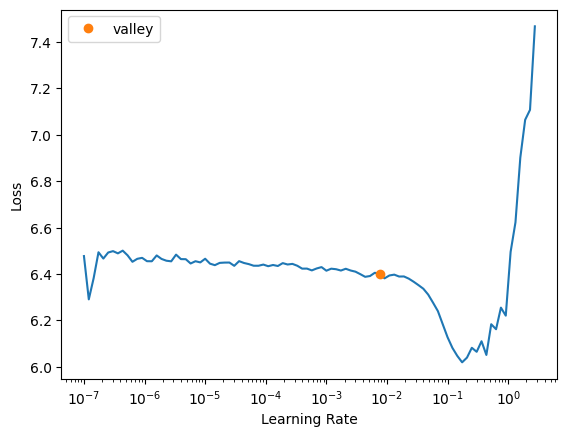

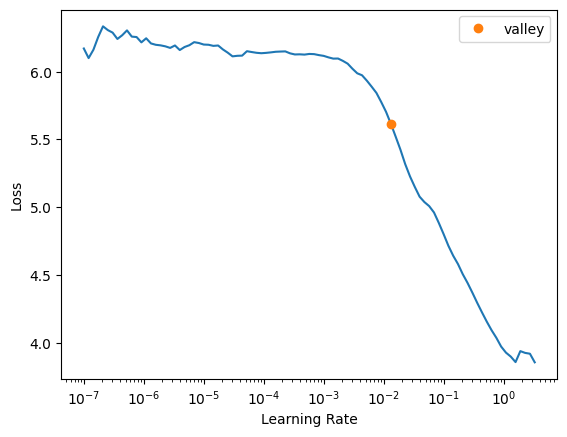

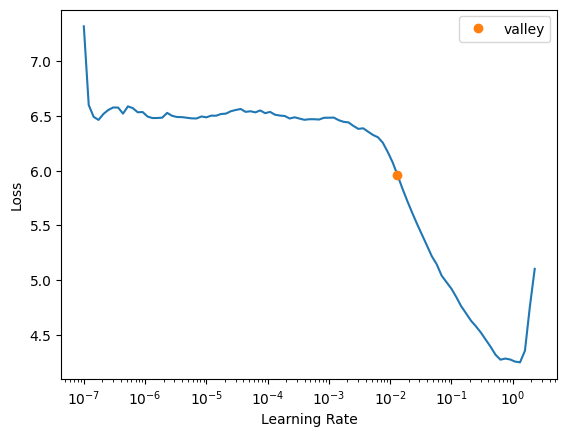

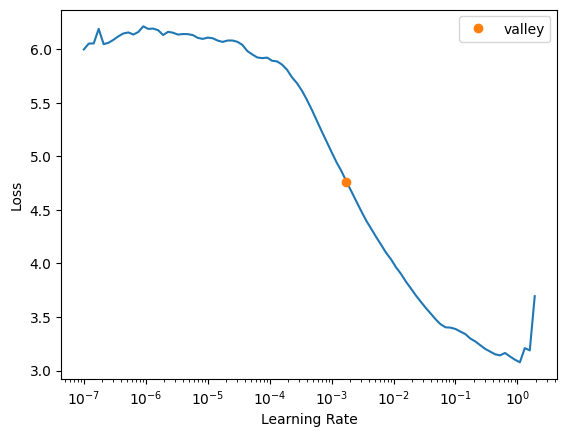

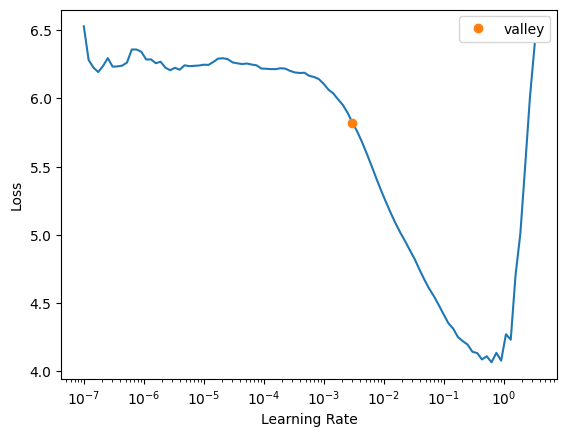

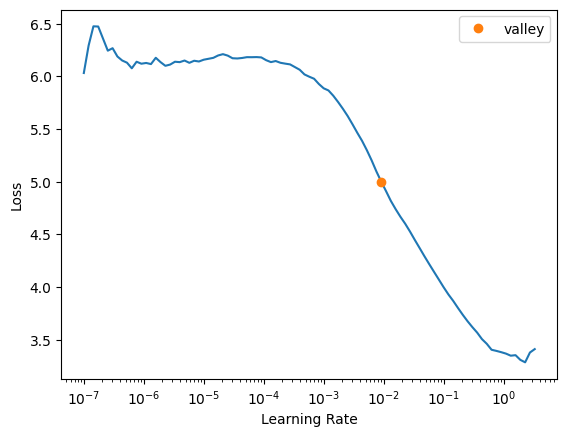

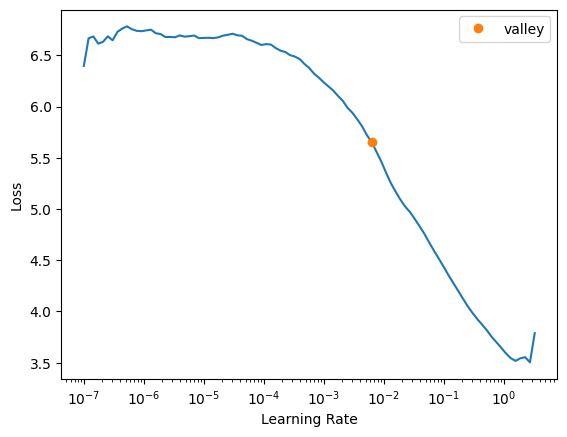

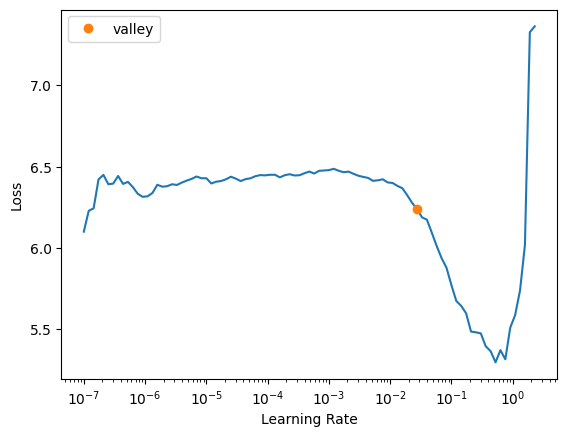

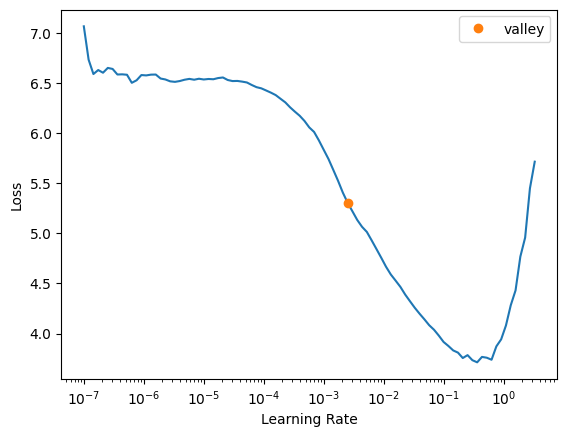

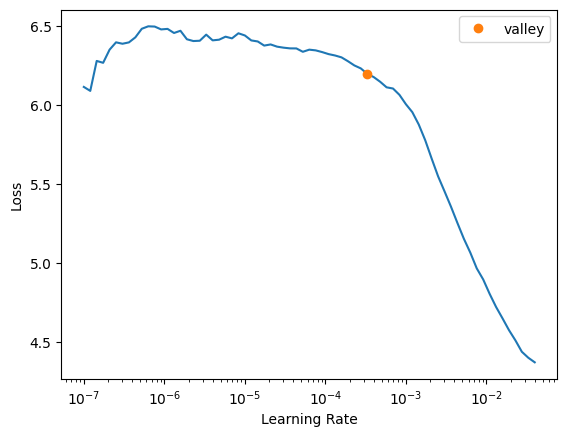

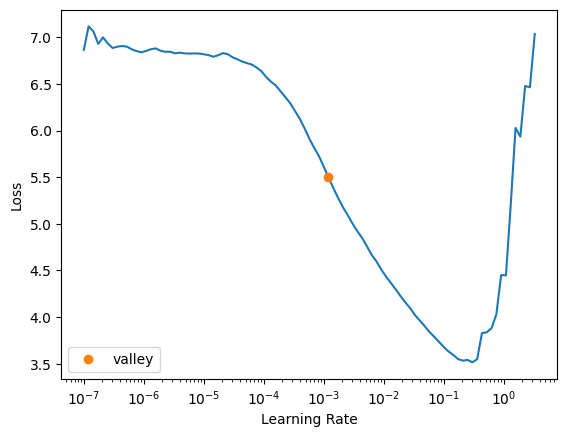

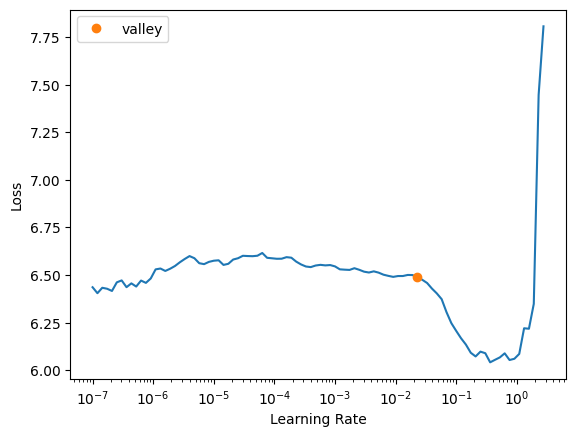

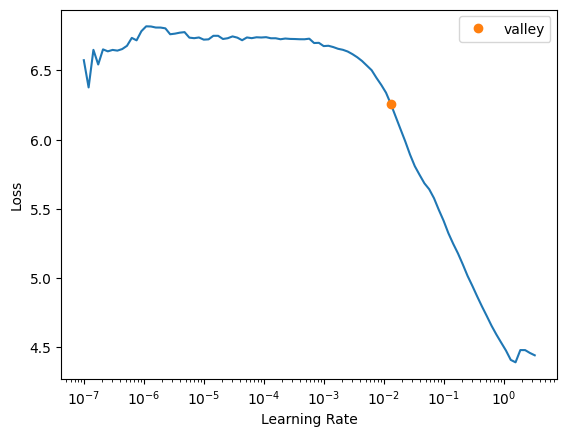

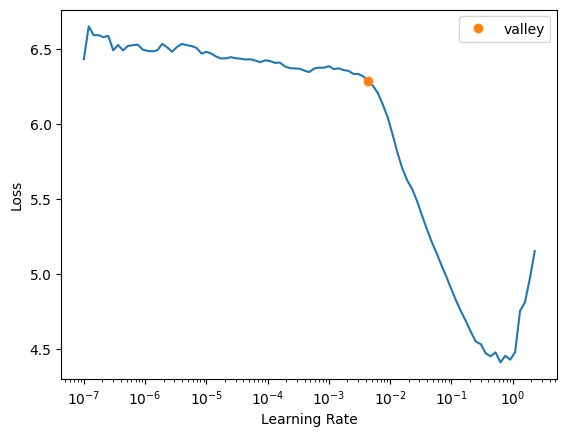

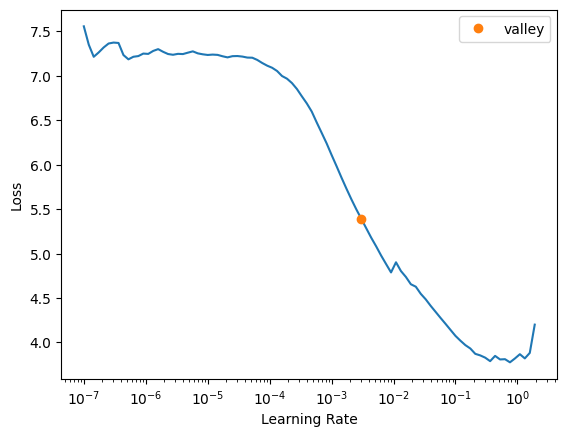

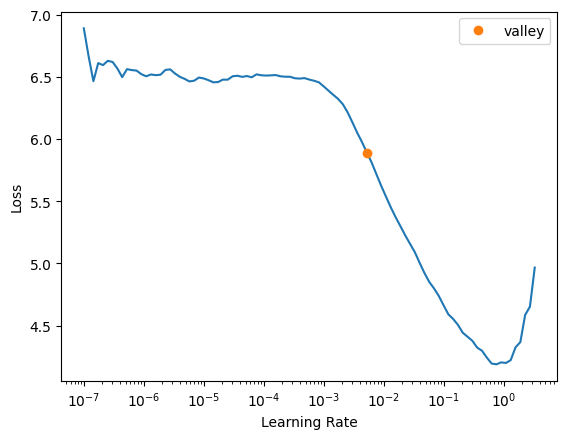

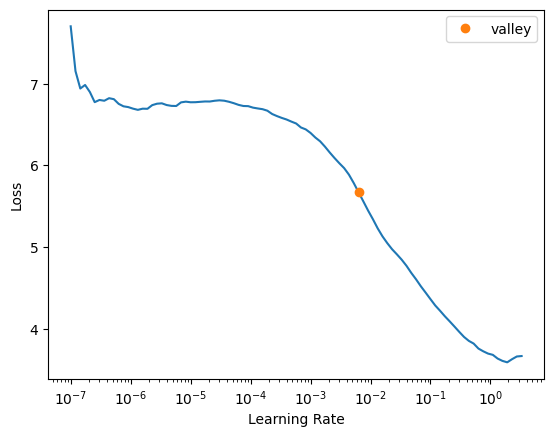

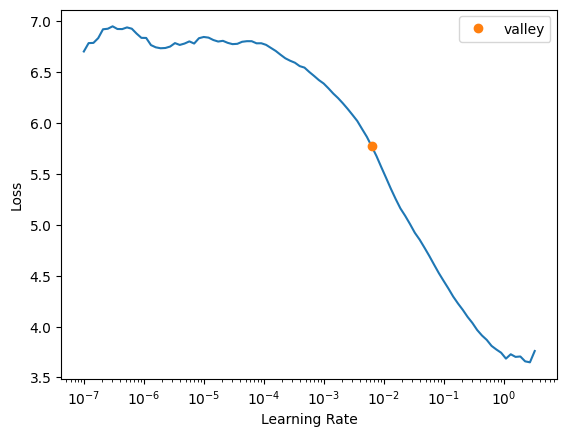

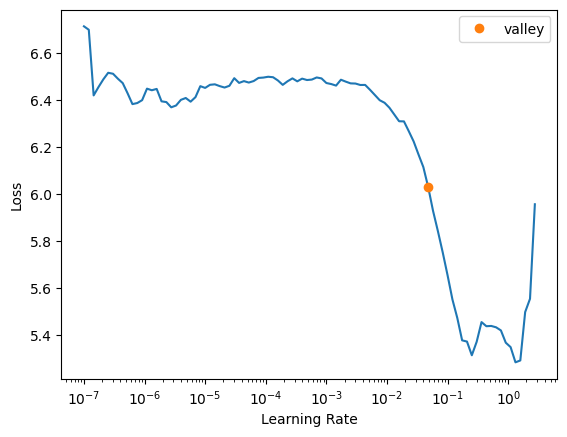

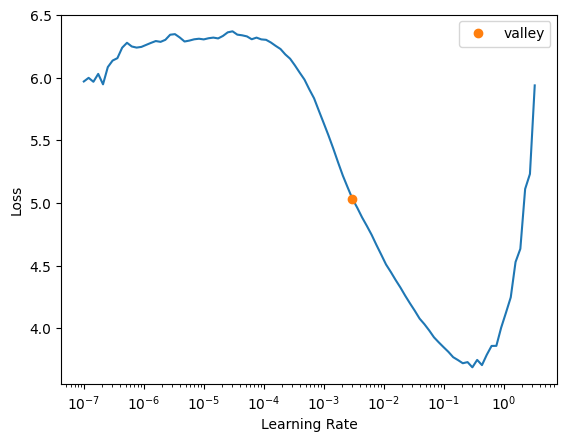

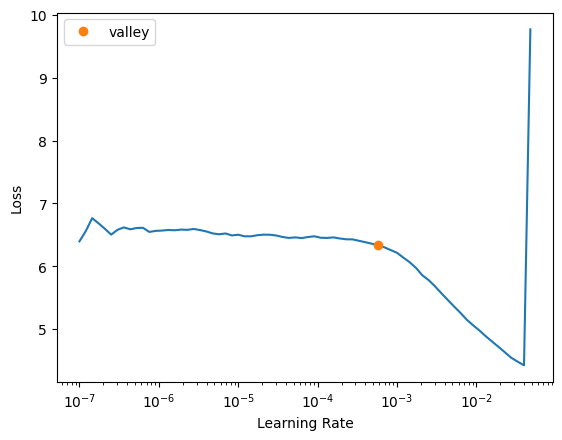

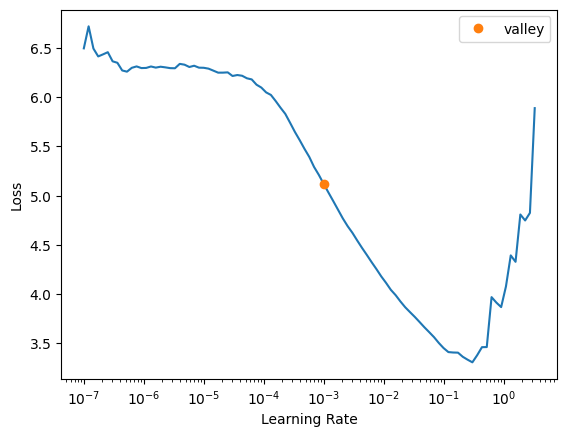

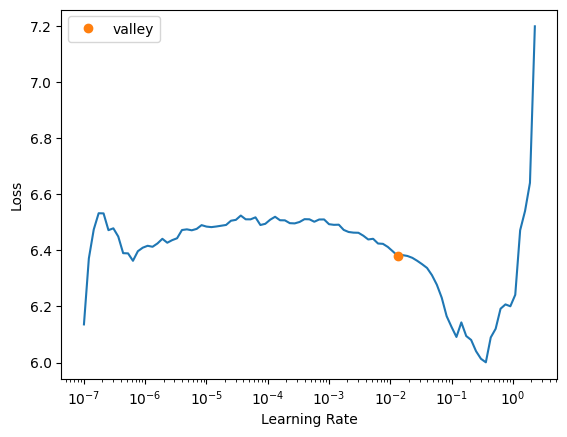

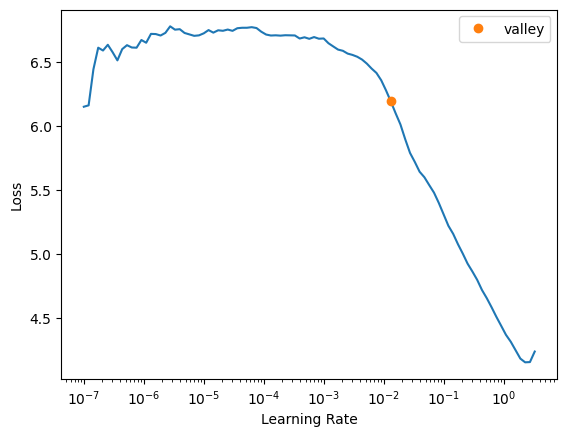

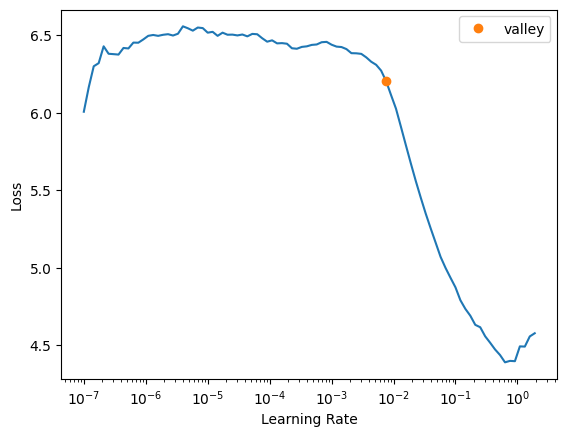

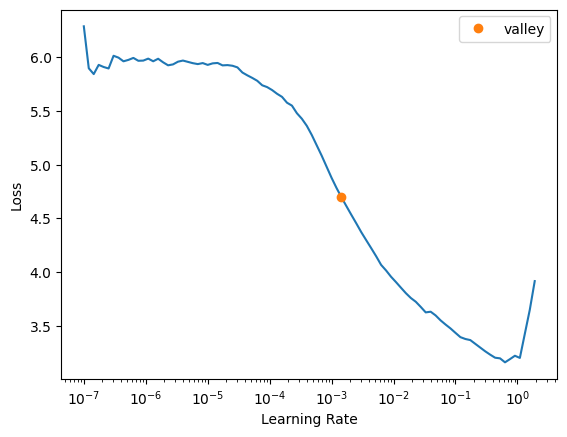

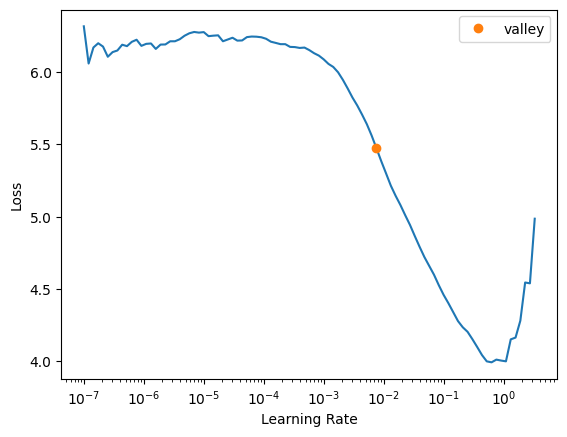

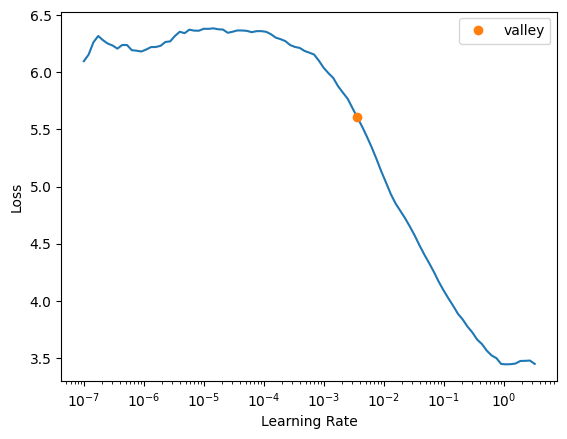

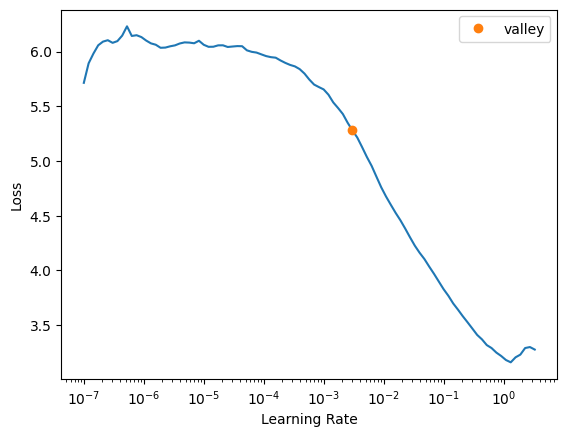

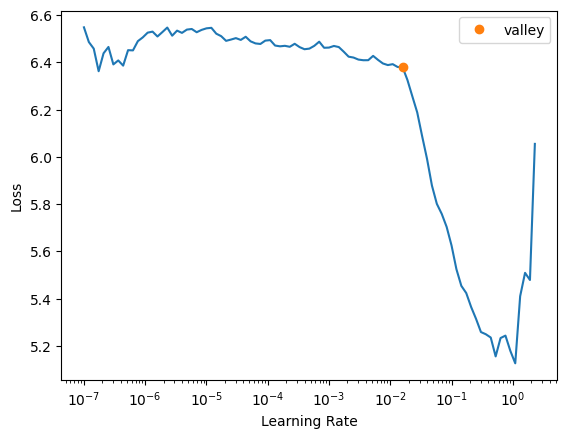

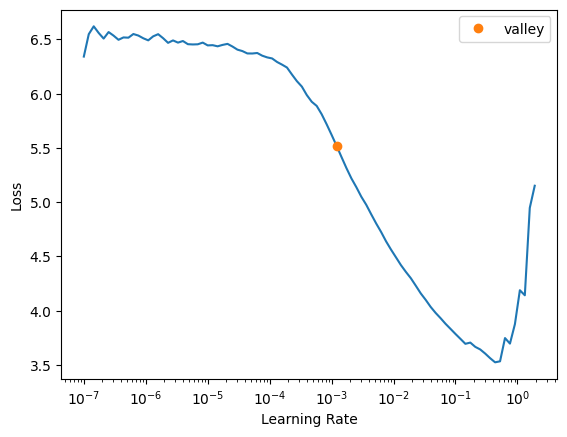

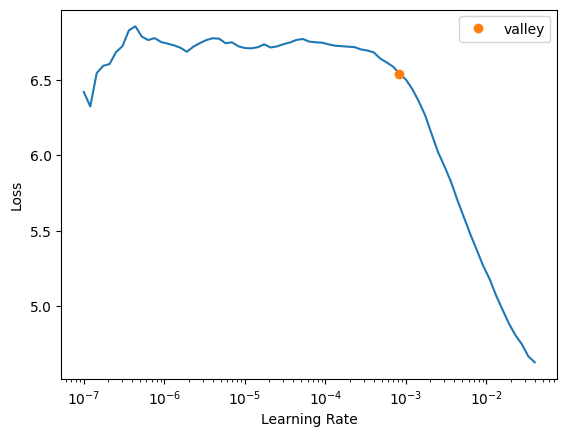

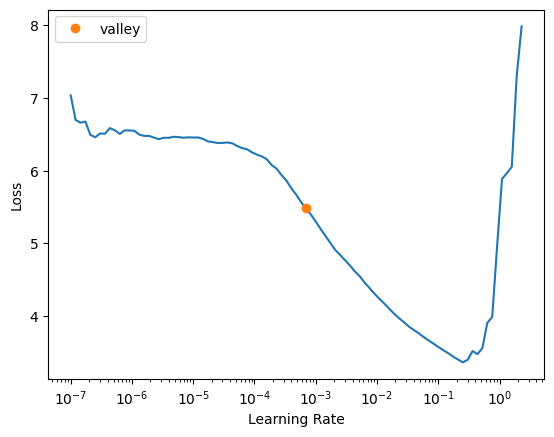

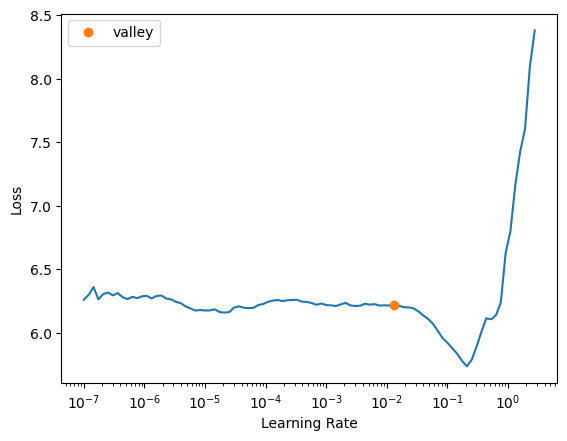

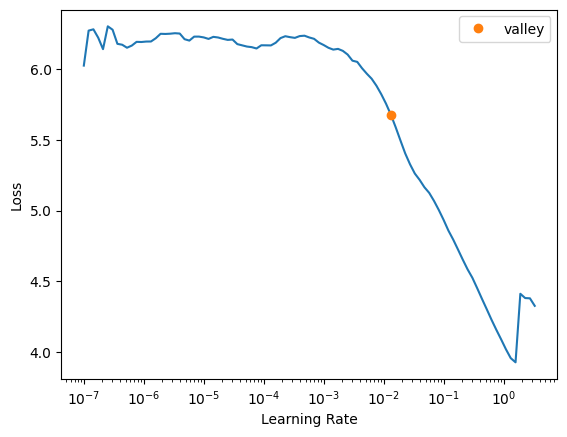

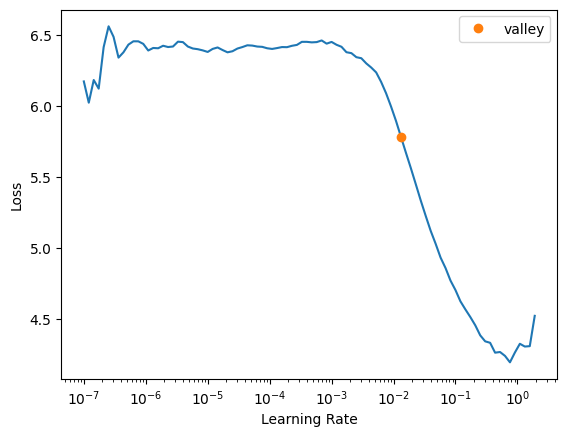

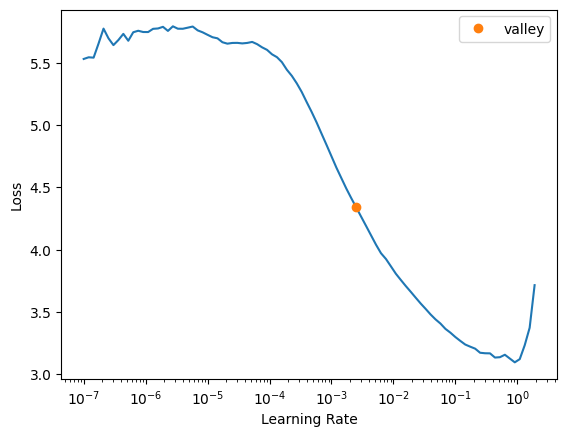

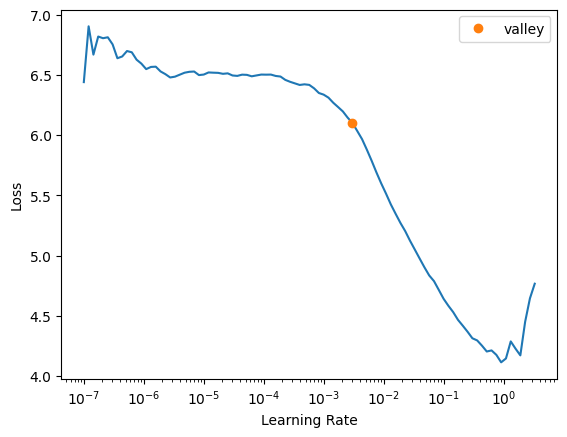

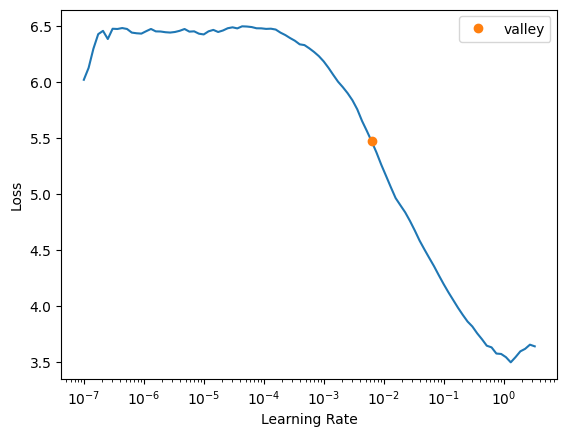

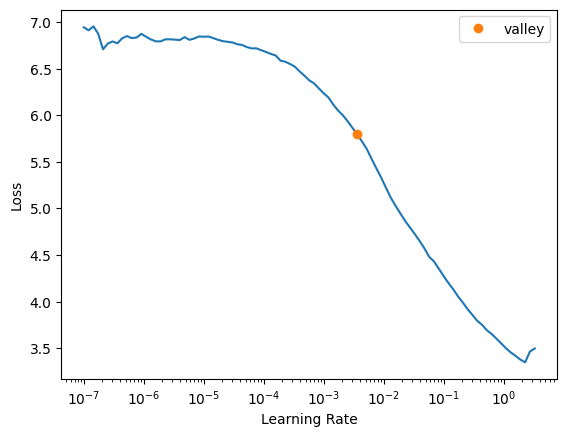

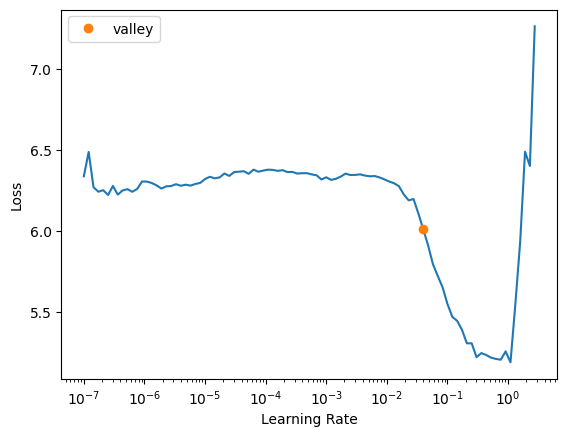

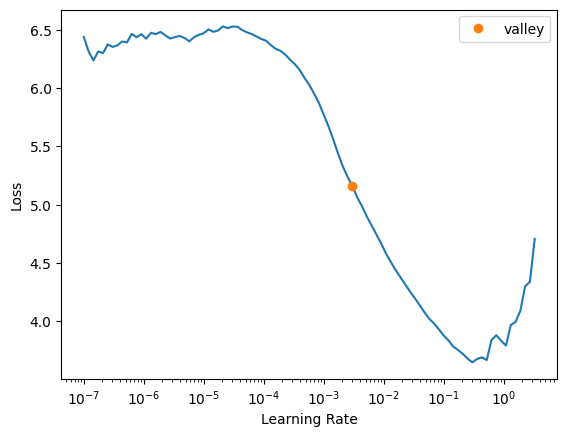

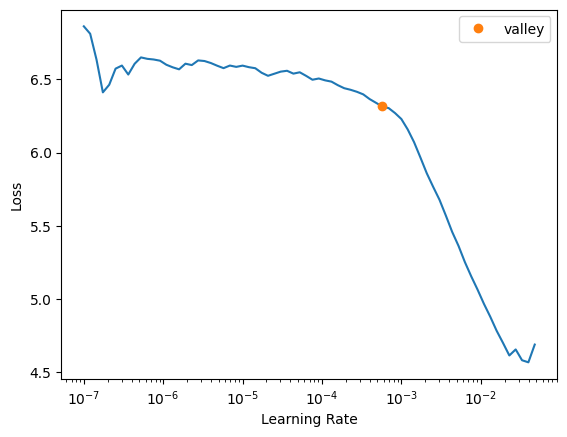

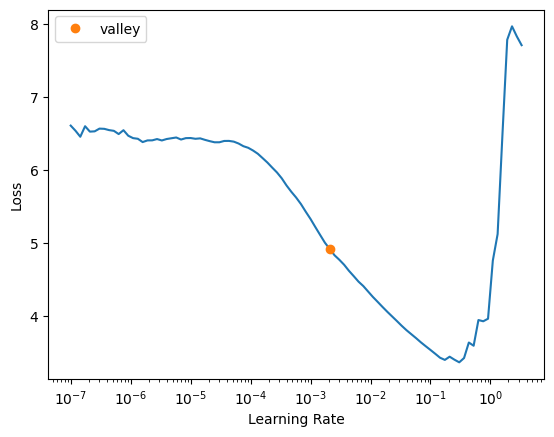

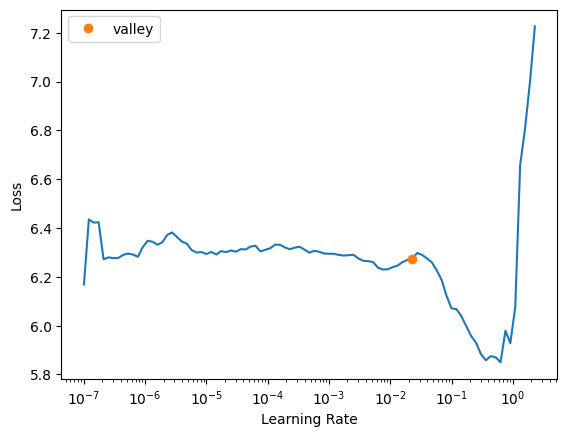

In [50]:
def test_archs(epochs):
    results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'mae_valid','rmse_valid','mae_test','rmse_test','time'])
    i=0
    for _, (arch, k) in enumerate(archs):
        print(arch.__name__)
        learn = TSForecaster(X, y, splits=splits, path='models', tfms=tfms, batch_tfms=TSStandardize(), arch=arch, metrics=[mae,rmse],device=default_device(),loss_func=HuberLoss('mean'))
        with ContextManagers([learn.no_logging(), learn.no_bar()]):
            lr = learn.lr_find() # learning rate find
            start = time.time()
            learn.fit_one_cycle(epochs, lr_max=lr.valley)
            elapsed = time.time() - start
        vals = learn.recorder.values[-1]
        raw_preds, target, _ = learn.get_X_preds(X[splits[2]], y[splits[2]])
        mae_test = mean_absolute_error(raw_preds.flatten(),target.flatten())
        mse_test = mean_squared_error(raw_preds.flatten(),target.flatten())
        rmse_test = np.sqrt(mse_test)
        results.loc[i] = [arch.__name__, k, count_parameters(learn.model), vals[0], vals[1], vals[2],vals[3],mae_test,rmse_test, int(elapsed)]
        results.sort_values(by=['mae_valid'], ascending=False, kind='stable', ignore_index=True, inplace=True)
        clear_output()
        display(results)
        i+=1
    results.to_csv(f'resultados_{epochs}_epocas.csv')

for epocas in range(100,350,50):
    test_archs(epocas)

In [31]:
# def objective(trial):
#     # Categorical parameter
#     #arch_name = trial.suggest_categorical('arch',list(architectures.keys()))
#     optimizer_name = trial.suggest_categorical("optimizer", list(otimizadores.keys()))

#     # Integer parameter
#     optimizer = otimizadores[optimizer_name]

#     dim_ff = trial.suggest_int('dim_ff',128,384)

#     encoder_dropout = trial.suggest_float('encoder_dropout', 0.0, 0.8)

#     fc_dropout = trial.suggest_float('fc_dropout', 0.0, 0.8)

#     abs_pos_encode = trial.suggest_categorical('abs_pos_encode', ['tAPE', 'sin', 'learned', None])

#     rel_pos_encode = trial.suggest_categorical('rel_pos_encode', ['eRPE', 'vector', None])

#     arch_config = {
#         'dim_ff': dim_ff,
#         'encoder_dropout': encoder_dropout,
#         'fc_dropout': fc_dropout,
#         'abs_pos_encode': abs_pos_encode,
#         'rel_pos_encode': rel_pos_encode
#     }
#     learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps

#     #learning_rate_model = trial.suggest_float("learning_rate_model", 1e-5, 1e-2, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
#     Huber_delta = trial.suggest_float("Huber_delta", 1, 2)
#     bs = trial.suggest_int('bs',32,256)
#     arch = ConvTranPlus

#     learn = TSForecaster(X, y, splits=splits, path='models', tfms=tfms, bs = bs,
#                          batch_tfms=TSStandardize(),arch=f"{arch.__name__}",
#                          arch_config= arch_config, metrics= [mae,rmse],
#                          #cbs=[ShowGraph(),PredictionDynamics(alpha=.5, size=75)],
#                          opt_func=wrap_optimizer(optimizer),loss_func=HuberLoss('mean',Huber_delta),seed=1)
#     with ContextManagers([learn.no_logging(), learn.no_bar()]):
#         for epoch in range(200):
#             learn.fit_one_cycle(1,lr_max=learning_rate)
#             # Report intermediate value
#             intermediate_value = learn.recorder.values[-1][1]
#             trial.report(intermediate_value, epoch)

#             # Check if trial should be pruned
#             if trial.should_prune():
#                 raise optuna.TrialPruned()

#     return intermediate_value


# study = run_optuna_study(objective,sampler= optuna.samplers.TPESampler(n_startup_trials=30), pruner=optuna.pruners.PatientPruner(optuna.pruners.HyperbandPruner(min_resource=5, max_resource=200, reduction_factor=3, bootstrap_count=3), patience=40),n_trials=300,gc_after_trial=True,direction="minimize",show_plots=False)

In [32]:
# learning_rate = study.best_trial.params['learning_rate']
# #learning_rate = best_params['learning_rate']
# optimizer = otimizadores[study.best_trial.params['optimizer']]
# #optimizer = otimizadores[best_params['optimizer']]
# delta = study.best_trial.params['Huber_delta']
# #delta = best_params['Huber_delta']
# params_without_lr = {key: value for key, value in study.best_trial.params.items() if (key != 'learning_rate') and (key != 'optimizer') and (key != 'Huber_delta')}
# #params_without_lr = {key: value for key, value in best_params.items() if (key != 'learning_rate') and (key != 'optimizer') and (key != 'Huber_delta')}

# learn = TSForecaster(X, y, splits=splits, path='models', tfms=tfms,
#                          batch_tfms=TSStandardize(),arch=f"{XCMPlus.__name__}",
#                          metrics= [mae,rmse],#arch_config= params_without_lr, 
#                          #cbs=[ShowGraph(),PredictionDynamics(alpha=.5, size=75)],
#                          loss_func=HuberLoss('mean',1.8),seed=1)#,opt_func=wrap_optimizer(optimizer))
# learn.fit_one_cycle(200,lr_max=learning_rate)

In [33]:
# raw_preds, target, preds = learn.get_X_preds(X[splits[2]], y[splits[2]])
# mae_test = mean_absolute_error(raw_preds,target)
# mse_test = mean_squared_error(raw_preds,target)
# rmse_test = np.sqrt(mse_test)
# r2_test = r2_score(y_pred=raw_preds,y_true=target)
# print(r2_test)
# print(mae_test)
# print(rmse_test)
# print(np.corrcoef(raw_preds.flatten(), target.flatten()))

In [34]:
# preds_df = pd.concat([pd.DataFrame(raw_preds),y_labels.to_frame()],axis=1)
# target_df = pd.concat([pd.DataFrame(y_test),y_labels.to_frame()],axis=1)

# dfs_preds = {}
# dfs_target = {}

# for localidade in preds_df['localidade'].unique():
#     dfs_preds[localidade] = preds_df[preds_df['localidade'] == localidade]

# for localidade in target_df['localidade'].unique():
#     dfs_target[localidade] = target_df[target_df['localidade'] == localidade]

# # Acessando os DataFrames separados

# df_peru_pred = dfs_preds['peru'].drop('localidade',axis=1)
# df_santarem_pred = dfs_preds['santarem'].drop('localidade',axis=1)
# df_caxiuana_pred = dfs_preds['caxiuana'].drop('localidade',axis=1)
# df_guiana_pred = dfs_preds['guiana'].drop('localidade',axis=1)

# df_peru_target = dfs_target['peru'].drop('localidade',axis=1)
# df_santarem_target = dfs_target['santarem'].drop('localidade',axis=1)
# df_caxiuana_target = dfs_target['caxiuana'].drop('localidade',axis=1)
# df_guiana_target = dfs_target['guiana'].drop('localidade',axis=1)

In [35]:
# plt.figure(figsize=(40, 6))
# plt.plot(df_santarem_pred.values.flatten(), label='Previsões', alpha=1)
# plt.plot(df_santarem_target.values.flatten(), label='Valores reais', alpha=0.7)
# plt.xlabel('Índice da observação')
# plt.ylabel('Valor')
# plt.title('Comparação entre Previsões e Valores Reais')
# plt.legend()
# plt.grid(True)
# plt.show()

In [36]:
# from scipy.ndimage import gaussian_filter1d

# # Aplicar suavização aos dados
# smoothed_raw_preds = gaussian_filter1d(df_santarem_pred.values.flatten(), sigma=3)
# smoothed_target = gaussian_filter1d(df_santarem_target.values.flatten(), sigma=3)

# # Plotar os dados suavizados
# plt.figure(figsize=(40, 6))
# plt.plot(smoothed_raw_preds, label='Previsões (suavizado)', alpha=1)
# plt.plot(smoothed_target, label='Valores reais (suavizado)', alpha=0.8)
# plt.xlabel('Índice da observação')
# plt.ylabel('Valor')
# plt.title('Comparação entre Previsões e Valores Reais (Suavizado)')
# plt.legend()
# plt.grid(True)
# plt.show()

In [37]:
# # Calcular os resíduos
# residuos = df_santarem_pred.values - df_santarem_target.values

# # Plotar os dados originais
# plt.figure(figsize=(30, 9))

# # Subplot com zoom na região de interesse
# plt.subplot(2, 1, 1)
# plt.plot(df_santarem_pred.values.flatten(), label='Previsões', alpha=1)
# plt.plot(df_santarem_target.values.flatten(), label='Valores reais', alpha=0.7)
# plt.xlabel('Índice da observação')
# plt.ylabel('Valor')
# plt.title('Comparação entre Previsões e Valores Reais (Zoom)')
# plt.legend()
# plt.grid(True)

# # Subplot dos resíduos
# plt.subplot(2, 1, 2)
# plt.plot(residuos.flatten(), label='Resíduos', color='red')
# plt.xlabel('Índice da observação')
# plt.ylabel('Resíduo')
# plt.title('Resíduos (Previsões - Valores reais)')
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()